## config

In [1]:
from dotenv import load_dotenv
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization
from module.for_model.training import construct_and_train_model
from module.for_model.checkpoint import save_checkpoint

In [2]:
load_dotenv(".env")

True

## Dataset

In [3]:
X_train, Y_train, X_test, Y_test = create_dataset(0,20000)

### Preprocess

In [4]:
# reshape for the model output
Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))


In [5]:
# normalize
normalizer = normalization(X_train)
X_train_n = normalizer.normalize(X_train)
Y_train_n = normalizer.normalize(Y_train)
X_test_n = normalizer.normalize(X_test)
Y_test_n = normalizer.normalize(Y_test)

In [6]:
# zip
data = [X_train_n, Y_train_n, X_test_n, Y_test_n]

## Train and Record

In [7]:
folder_test_name = "2024_0604_2219"
path_folder = f"checkpoints\\{folder_test_name}"

for n in range(1,21):
    print(f"n = {n}")

    folder_node = f"node_{n:02d}"
    path_folder = f"checkpoints\\{folder_test_name}\\{folder_node}"

    loss_n = []
    param_n = []
    # 用 30 個不同的 randam seed 訓練 30 個不同的模型
    for layer_initializer in range(30):
        print(f"\tlayer_initializer = {layer_initializer}")    

        ttl_loss, ttl_param = \
            construct_and_train_model(
                n = n,
                layer_initializer = layer_initializer,
                data = data
            )
        loss_n.append(ttl_loss)
        param_n.append(ttl_param)


    save_checkpoint(path_folder, loss_n, param_n)

    

	layer_initializer = 0


# Drawing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from module.for_model.checkpoint import load_checkpoint
from module.draw.draw import specific_loss

### (1) 盒鬚圖
不同隱藏層神經元數量 (n=[1,20])下的 30 次建模結果盒鬚圖

In [ ]:
name_test = "2024_0604_2219"
type_loss = 1

ttl_loss_out = [specific_loss(name_test, n, type_loss) for n in range(1,21)]

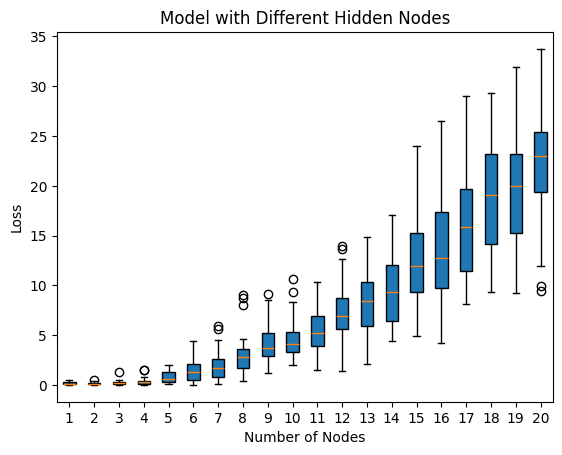

In [ ]:
plt.boxplot(data, patch_artist=True)

# 添加标题和标签
plt.title("Model with Different Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Loss")

# 显示图表
plt.show()